In [497]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, nsolve
from sympy import cosh, sin , sinh, cos,exp
from scipy.special import factorial
from scipy.special import sph_harm_y    #sph_harm_y(l,m,theta,phi)
from scipy.optimize import fsolve,brentq
from scipy.integrate import quad,quad_vec
import numba,time
from decimal import Decimal, getcontext
from scipy.interpolate import interp1d
from joblib import Parallel, delayed   #parallel acceleration
getcontext().prec = 50  #decimal precision

In [498]:
#System
e2=1.43997 ; hbarc=197.3269718 ; amu=931.49432
zp=69 ; Ap=145 ; mass_excess_p=-27.58 ; mp=Ap*amu+mass_excess_p
z1=68 ; A1=144 ; mass_excess_1=-36.61 ; m1=A1*amu+mass_excess_1    #1-> daughter
z2=1  ; A2=1   ; mass_excess_2=7.288971064 ; m2=A2*amu+mass_excess_2
Q=mp-m1-m2
mu=m1*m2/(m1+m2)
P0=0.580
#Potential

#Deformation
beta2 = 0.231  # quadrupole
beta4 = -0.068  # hexadecapole 

#Polarizaton
beta2tilde = 0  
beta4tilde = 0

#spin-orbit
Vso0=6.2 ; rso=1.01*(A1)**(1/3) ; aso=0.75 ; lambda_pi=np.sqrt(2)
L=5; S=0.5; J=5.5

#Vn
a0=0.75 ; r0=1.27*A1**(1/3)-0.1 ; V0=55

#Vc
Rc0 = 1.21 * A1**(1/3)          

#mesh
r = np.linspace(0.03, 30.0, 1000) # avoid too small r


$\frac{\partial}{\partial \theta}Y_{l,m}(\theta,\phi)=\frac{1}{(2l+1)\sin\theta}\left [l(l-m+1)\frac{N_{l,m}}{N_{l+1,m}}Y_{l+1,m}(\theta,\phi)-(l+1)(l+m)\frac{N_{l,m}}{N_{l-1,m}}Y_{l-1,m}(\theta,\phi)]      \right],N_{l,m}=\sqrt{\frac{(2l+1)(l-m)!}{4\pi(l+m)!}}$

$V_{so}=V_{so0}\lambda_\pi^2\frac{1}{r}\frac{d}{dr}\frac{1}{1+\exp[(r-R_{so})/a_{so}]}\vec{\sigma}\cdot\vec{l}=\frac{V_{so0}\lambda_\pi^2}{a_{so}}\times \frac{-e^{\frac{r-R_{so}}{a_{so}}}}{r(1+e^{\frac{r-R_{so}}{a_{so}}})^2}\times\frac{J(J+1)-L(L+1)-S(S+1)}{2}\times2$


Piecewise $K_{\lambda}(r,\theta,\phi)$ with $m=0$ and deformed Coulomb


$V_{cent}=\frac{\hbar^2(l+0.5)^2}{2\mu r^2}$

In [499]:

Nlm=lambda l,m: np.sqrt((2*l+1)/(4*np.pi)*factorial(l-m)/factorial(l+m))
#derivative of Ylm on theta, theta exists on the denominator, so use epsilon to avoid division by zero

def dYlm(l,m,theta,phi):
    if np.sin(theta) <1e-10:
        return 0
    return (1/(2*l+1)/(np.sin(theta)))*(l*(l-m+1)*Nlm(l,m)/Nlm(l+1,m)*sph_harm_y(l+1,m,theta,phi)-(l+1)*(l+m)*Nlm(l,m)/Nlm(l-1,m)*sph_harm_y(l-1,m,theta,phi))
#deformed potential,with deformed paras beta, polarization params beta_tilde
#Avoid using zero theta, if needed, set theta=1e-10
def Vn(V0,r0,a0,beta2,beta4,beta2_tilde,beta4_tilde,r,theta):
    Y20=sph_harm_y(2,0,theta,0)  #sph_harm_y(l,m,theta,phi)
    Y40=sph_harm_y(4,0,theta,0)
    r0_theta=r0*(1+beta2*Y20+beta4*Y40)         #deformation

    # delta_theta=1e-6
    # dY20=(sph_harm(0, 2, 0, theta+delta_theta)-sph_harm(0, 2, 0, theta))/(delta_theta)
    # dY40=(sph_harm(0, 4, 0, theta+delta_theta)-sph_harm(0, 4, 0, theta))/(delta_theta)
    dY20=dYlm(2,0,theta,0)
    dY40=dYlm(4,0,theta,0)
    dr0_theta=r0*(beta2*dY20+beta4*dY40)       

# polarization
    a0_theta=a0*np.sqrt(1+(1/r0_theta*dr0_theta)**2)*(1+beta2_tilde*Y20+beta4_tilde*Y40) 

    return -V0/(1+np.exp((r-r0_theta)/a0_theta))

#V_{so}, with lambda_pi being the wave number of pion
def Vso(Vso0,rso,aso,L,S,J,r,theta,beta2,beta4,beta2_tilde,beta4_tilde):
    lambda_pi2=2
    Y20=sph_harm_y(2,0,theta,0)  #sph_harm_y(l,m,theta,phi)
    Y40=sph_harm_y(4,0,theta,0)
    dY20=dYlm(2,0,theta,0)
    dY40=dYlm(4,0,theta,0)
    #deformation
    rso=rso*(1+beta2*Y20+beta4*Y40) 

    #polarization
    drso=rso*(beta2*dY20+beta4*dY40)       
    aso=aso*np.sqrt(1+(1/rso*drso)**2)*(1+beta2_tilde*Y20+beta4_tilde*Y40) 
    return Vso0*lambda_pi2/aso*(-np.exp((r-rso)/aso)/(r*(1+np.exp((r-rso)/aso))**2))*((J*(J+1)-L*(L+1)-S*(S+1))/2)*2

def Vc_vectorized(z1, z2, r, theta, Rc0, beta2, beta4):
    """
    Vectorized deformed-nucleus Coulomb potential.
    r can be scalar or any numpy array.
    """
    r = np.asarray(r)  # ensure array

    # Fixed outer angle (evaluation point)
    Y00 = sph_harm_y(0, 0, theta, 0).real     #m,l,phi,theta
    Y20 = sph_harm_y(2, 0, theta, 0).real
    Y40 = sph_harm_y(4, 0, theta, 0).real
    Rc_fixed = Rc0 * (1 + beta2*Y20 + beta4*Y40)   # Rc at observation angle

    # Rc as function of integration variable
    def Rc_of_theta(t):
        return Rc0 * (1 + beta2*sph_harm_y(2,0,t,0).real + beta4*sph_harm_y(4,0,t,0).real)

    # Vectorized Kλ(l, r, θ_int)
    def Klambda(lam, rrr, t):
        inside = rrr <= Rc_of_theta(t)
        res = np.zeros_like(rrr)

        if lam == 2:
            res[inside]  = rrr[inside]**2/5 + rrr[inside]**2*np.log(Rc_of_theta(t)/rrr[inside])
            res[~inside] = Rc_of_theta(t)**(lam+3)/((lam+3)*rrr[~inside]**(lam+1))
        else:
            res[inside]  = (2*lam+1)*rrr[inside]**2/((lam+3)*(lam-2)) - rrr[inside]**lam/((lam-2)*Rc_of_theta(t)**(lam-2))
            res[~inside] = Rc_of_theta(t)**(lam+3)/((lam+3)*rrr[~inside]**(lam+1))
        return res

    # Integrand for given multipole λ
    def integrand_lam(t, lam):
        Yl0 = sph_harm_y(lam, 0, t, 0).real
        return Yl0 * Klambda(lam, r, t) * np.sin(t)

    # Vectorized integration (0 → π/2, then ×2 for full sphere)
    res0 = 2 * quad_vec(lambda t: integrand_lam(t, 0), 0, np.pi/2,
                        epsabs=1e-10, epsrel=1e-10)[0]
    res2 = 2 * quad_vec(lambda t: integrand_lam(t, 2), 0, np.pi/2,
                        epsabs=1e-10, epsrel=1e-10)[0]
    res4 = 2 * quad_vec(lambda t: integrand_lam(t, 4), 0, np.pi/2,
                        epsabs=1e-10, epsrel=1e-10)[0]

    V_0 = 3*z1*z2*e2 / Rc0**3 * 2*np.pi * Y00*res0
    V_2 = 3*z1*z2*e2 / Rc0**3 * 2*np.pi * Y20/5*res2
    V_4 = 3*z1*z2*e2 / Rc0**3 * 2*np.pi * Y40/9*res4
    
    # Final Coulomb potential
    Vc_tot = V_0 + V_2 + V_4

    return Vc_tot, V_0, V_2, V_4

In [500]:
def compute_gamma_for_theta(theta, m1, m2, z1, z2, Rc0, V0, a0, r0, P0, beta2, beta4, beta2tilde, beta4tilde):

#mesh
    r_values = np.linspace(0.1, 100.0, 300)   # for searching roots
    r_grid   = np.linspace(0.05, 100.0, 1000) # for interpolation

#pre calculate Vn, Vso, Vc
    Vn_grid   = Vn(V0, r0, a0, beta2, beta4, beta2tilde, beta4tilde, r_grid, theta)
    Vso_grid  = Vso(Vso0, rso, aso, L, S, J, r_grid, theta, beta2, beta4, beta2tilde, beta4tilde)
    Vc_grid, _, _, _ = Vc_vectorized(z1, z2, r_grid, theta, Rc0, beta2, beta4)

#interpolate Vn, Vso, Vc
    interp_Vn  = interp1d(r_grid, Vn_grid,   kind='cubic', fill_value="extrapolate", bounds_error=False)
    interp_Vso = interp1d(r_grid, Vso_grid,  kind='cubic', fill_value="extrapolate", bounds_error=False)
    interp_Vc  = interp1d(r_grid, Vc_grid,   kind='cubic', fill_value="extrapolate", bounds_error=False)

    def f(r):
        V_cent = hbarc**2 * (L + 0.5)**2 / (2 * mu * r**2)
        return interp_Vn(r) + interp_Vso(r) + interp_Vc(r) + V_cent - Q

    def k(r):
        V_cent = hbarc**2 * (L + 0.5)**2 / (2 * mu * r**2)
        Vtot = interp_Vn(r) + interp_Vso(r) + interp_Vc(r) + V_cent
        arg = (2 * mu / hbarc**2) * np.abs(Vtot - Q)
        return np.sqrt(np.maximum(arg, 0.0))

    def integrand(r):
        return 1 / (2 * k(r))

# Find roots
    f_values = f(r_values)
    roots = []
    for i in range(len(r_values)-1):
        if np.sign(f_values[i]) != np.sign(f_values[i+1]):
            try:
                root = brentq(f, r_values[i], r_values[i+1], xtol=1e-6)
                if root > 0 and not any(np.isclose(root, r, atol=1e-5) for r in roots):
                    roots.append(root)
            except ValueError:
                pass
    roots.sort()

    if len(roots) < 3:
        return np.nan  

# Integrate
    integral_result, _ = quad(integrand, roots[0], roots[1], limit=50)
    F = 1 / integral_result

    action, _ = quad(k, roots[1], roots[2], limit=100)
    Gamma = P0 * F * hbarc**2 / (4 * mu) * np.exp(-2 * action)

    return Gamma


def Model(m1, m2, z1, z2, Rc0, V0, a0, r0, P0, beta2, beta4, beta2tilde, beta4tilde, n_theta=120):

    start_time = time.time()

    theta_grid = np.linspace(0, np.pi, n_theta)

    print(f"开始计算 {n_theta} 个 theta 点...")

    # 并行计算每个 theta 的 Gamma（最关键的加速点）
    gamma_list = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_gamma_for_theta)(
            theta, m1, m2, z1, z2, Rc0, V0, a0, r0, P0, beta2, beta4, beta2tilde, beta4tilde
        )
        for theta in theta_grid
    )

    Gamma_array = np.array(gamma_list)

    total_time = time.time() - start_time
    print(f"计算完成！总耗时: {total_time:.2f} 秒")
    print(f"平均每个 theta 耗时: {total_time / n_theta:.3f} 秒")

    # 可选：返回 theta 和 Gamma 的对应关系
    return theta_grid, Gamma_array

开始计算 80 个 theta 点...


/Users/bojizheng/miniconda3/lib/python3.12/site-packages/scipy/optimize/_zeros_py.py:846: ComplexWarning: Casting complex values to real discards the imaginary part
  r = _zeros._brentq(f, a, b, xtol, rtol, maxiter, args, full_output, disp)
/var/folders/b3/wwgr7yrd62xdrw_44kj1f4gh0000gn/T/ipykernel_2318/3108600680.py:47: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral_result, _ = quad(integrand, roots[0], roots[1], limit=50)
/var/folders/b3/wwgr7yrd62xdrw_44kj1f4gh0000gn/T/ipykernel_2318/3108600680.py:47: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be det

计算完成！总耗时: 59.24 秒
平均每个 theta 耗时: 0.740 秒


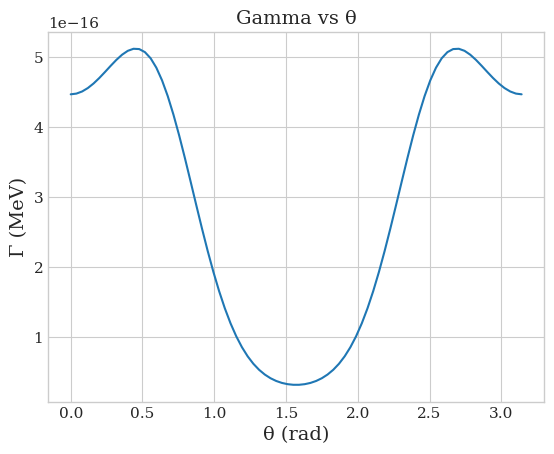

In [ ]:
theta_arr, Gamma_arr = Model(m1, m2, z1, z2, Rc0, V0, a0, r0, P0, beta2, beta4, beta2tilde, beta4tilde, n_theta=80)

# 画图查看
import matplotlib.pyplot as plt
plt.plot(theta_arr, Gamma_arr)
plt.xlabel("θ (rad)")
plt.ylabel("Γ (MeV)")
plt.title("Gamma vs θ")
plt.show()

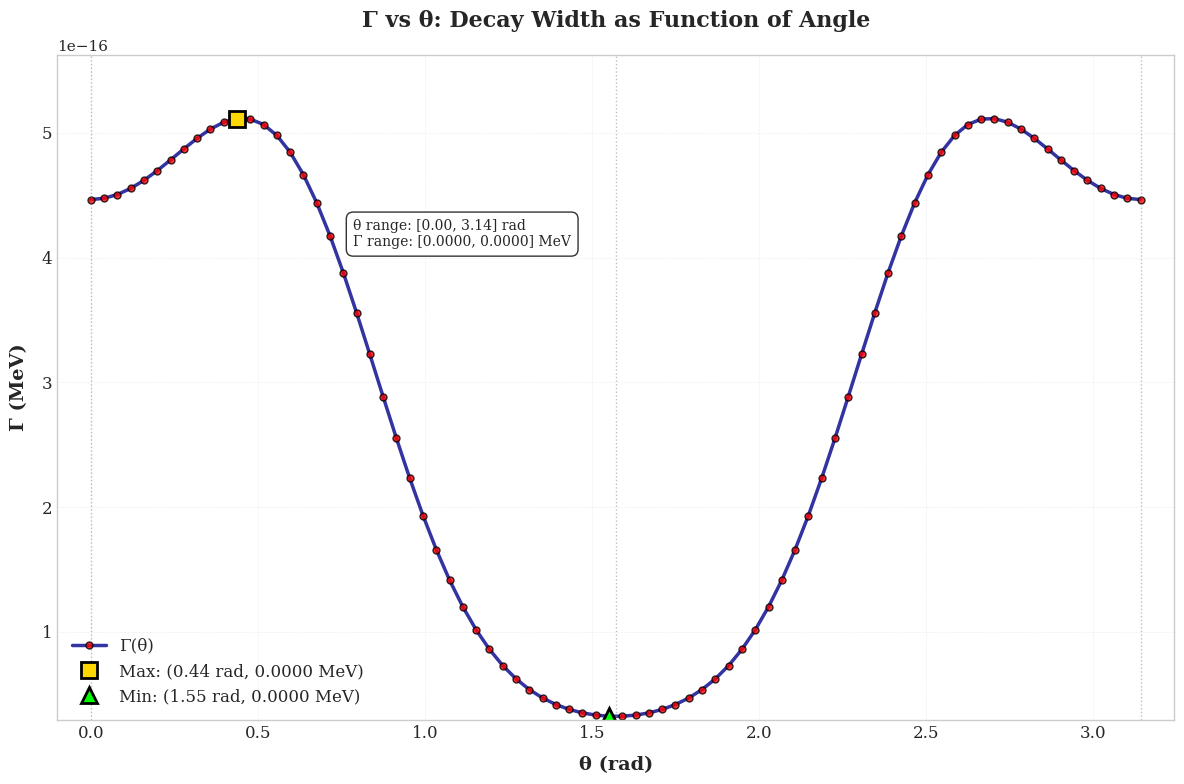

In [508]:
plt.figure(figsize=(12, 8))

# 绘制曲线
plt.plot(theta_arr, Gamma_arr, 
         color='darkblue',      # 颜色
         linewidth=2.5,         # 线宽
         marker='o',            # 数据点标记
         markersize=5,          # 标记大小
         markerfacecolor='red', # 标记填充色
         markeredgecolor='black', # 标记边框色
         markeredgewidth=1,     # 标记边框宽度
         alpha=0.8,             # 透明度
         linestyle='-',         # 线型：实线
         label='Γ(θ)')          # 图例标签

# 标记特殊点（如极值点）
if len(Gamma_arr) > 0:
    # 找到最大值
    max_idx = np.argmax(Gamma_arr)
    max_theta = theta_arr[max_idx]
    max_gamma = Gamma_arr[max_idx]
    
    plt.plot(max_theta, max_gamma, 's', 
             markersize=12, 
             markerfacecolor='gold', 
             markeredgecolor='black',
             markeredgewidth=2,
             label=f'Max: ({max_theta:.2f} rad, {max_gamma:.4f} MeV)')
    
    # 找到最小值（如果适用）
    min_idx = np.argmin(Gamma_arr)
    if min_idx != max_idx:  # 避免重复
        min_theta = theta_arr[min_idx]
        min_gamma = Gamma_arr[min_idx]
        plt.plot(min_theta, min_gamma, '^', 
                 markersize=12, 
                 markerfacecolor='lime', 
                 markeredgecolor='black',
                 markeredgewidth=2,
                 label=f'Min: ({min_theta:.2f} rad, {min_gamma:.4f} MeV)')

# 设置坐标轴
plt.xlabel("θ (rad)", fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel("Γ (MeV)", fontsize=14, fontweight='bold', labelpad=10)

# 设置标题
plt.title("Γ vs θ: Decay Width as Function of Angle", 
          fontsize=16, fontweight='bold', pad=20)

# 设置刻度
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 添加网格
plt.grid(True, which='both', alpha=0.3, linestyle='--', linewidth=0.5)

# 添加图例
plt.legend(fontsize=12, loc='best', framealpha=0.9, shadow=True)

# 设置坐标轴范围（可选）
if len(theta_arr) > 0:
    plt.xlim(min(theta_arr) - 0.1, max(theta_arr) + 0.1)
    plt.ylim(min(Gamma_arr) * 0.9, max(Gamma_arr) * 1.1)

# 添加背景色区域（可选）
# plt.axvspan(0, np.pi/2, alpha=0.1, color='blue', label='0-π/2')
# plt.axvspan(np.pi/2, np.pi, alpha=0.1, color='red', label='π/2-π')

# 添加角度标记线
plt.axvline(x=0, color='gray', linestyle=':', alpha=0.5, linewidth=1)
plt.axvline(x=np.pi/2, color='gray', linestyle=':', alpha=0.5, linewidth=1)
plt.axvline(x=np.pi, color='gray', linestyle=':', alpha=0.5, linewidth=1)

# 添加文本标注
plt.text(np.pi/4, max(Gamma_arr)*0.8, 
         f"θ range: [{min(theta_arr):.2f}, {max(theta_arr):.2f}] rad\n"
         f"Γ range: [{min(Gamma_arr):.4f}, {max(Gamma_arr):.4f}] MeV",
         fontsize=10, 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# 紧凑布局
plt.tight_layout()
# 可选：保存图形
plt.savefig('gamma_vs_theta.pdf',dpi=300)
# 显示图形
plt.show()

